In this notebook, we will demonstrate how to plot memory functions using calculated IPC files. 
The previous script illustrates the total capacities of echo state network (ESN), but it does not show its dependency on delays. Here we explain first- and second-order memory functions using an ESN. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from utils.information_processing_capacity import single_input_ipc

##### Parameters for esn #####
N = 50      # Number of nodes
Two = 10000 # Washout time
T = int(1e6)# Time length except washout
p = 0.5     # Sparsity for internal weight
pin = 0.1   # Sparsity for input weight
iota = 0.1  # Input intensity
rho = 0.5  # Spectral radius
#Weight
seed = 0
np.random.seed(seed)
win = (2*np.random.rand(N)-1) * (np.random.rand(N)<pin)
w = (2*np.random.rand(N,N)-1) * (np.random.rand(N,N)<p)
eig,eigv = np.linalg.eig(w)
w = w/np.max(np.abs(eig))

To depict both the first- and second-order memory functions, we apply an asymmetric input $\zeta_t\in[0,1]$ to the ESN, which holds both types of memories. 

In [3]:
##### Input #####
np.random.seed(0)
zeta_asym = np.random.rand(Two+T)
zeta_sym = 2*zeta_asym-1
print('zeta (symmetric)',zeta_sym,zeta_sym.shape)

# Parameters for IPC
poly = 'legendre'
distr = 'uniform'
degdelays = [[1,100],[2,30]]
# Class for IPC
ipc = single_input_ipc(zeta_sym,Two,degdelays,poly=poly,distr=distr,zerobased=True)

gpu_id = 0
cp.cuda.Device(gpu_id).use()

# Directory
pkldir = 'ipc/pkl'
path = '%s/asym_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,iota)

zeta (symmetric) [ 0.09762701  0.43037873  0.20552675 ...  0.61867435 -0.30313547
 -0.51697079] (1010000,)


In [6]:
# ESN
x = np.zeros((N,Two+T))
for t in range(1,Two+T):
    x[:,t] = np.tanh(rho*w.dot(x[:,t-1])+iota*win*zeta_asym[t-1])

##### Compute IPC of ESN state #####
ipc.svd(x)
ipc.save_config(path)
Ctot = 0
for deg,delay in degdelays:
    ipcs,surs = ipc.compute(deg,delay)
    truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2)
    Ctot_deg = np.sum(truncated['ipcs'].values)
    print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
    Ctot += Ctot_deg
print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
print('--------------------------------------------------------------------------------\n\n\n')

{'N': 50, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 100], [2, 30]], 'zerobased': True, 'poly': 'legendre', 'distr': 'uniform', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 47}
   degdelaysets      ipcs
1      [[1, 1]]  0.999998
2      [[1, 2]]  0.999998
3      [[1, 3]]  0.999998
4      [[1, 4]]  0.999998
5      [[1, 5]]  0.999998
6      [[1, 6]]  0.999998
7      [[1, 7]]  0.999998
8      [[1, 8]]  0.999997
9      [[1, 9]]  0.999997
10    [[1, 10]]  0.999993
11    [[1, 11]]  0.999988
12    [[1, 12]]  0.999958
13    [[1, 13]]  0.999765
14    [[1, 14]]  0.998323
15    [[1, 15]]  0.991900
16    [[1, 16]]  0.970086
17    [[1, 17]]  0.903928
18    [[1, 18]]  0.247113
19    [[1, 19]]  0.017166
20    [[1, 20]]  0.006050
21    [[1, 21]]  0.001101
22    [[1, 22]]  0.000263
23    [[1, 23]]  0.000103
deg 1 delay 100 Ctot(d) 17.135714654966076
           degdelaysets      ipcs
2              [[2, 1]]  0.974210
4              [[2, 2]]  0.975979
5      [[1, 1], [1, 2]]  0.

1. First-order memory function

The first-order memory function $C(\tau)$ describes an input delayed by $\tau$ held in a reservoir and is equivalent to the first-order IPC of $\zeta_{t-\tau}$. 
The method `single_input_ipc.mf1d()` returns the first-order memory function `mf1d` $\{C(\tau)\}$ with its corresponding delays `delays` $\{\tau\}$. 
Note that, when `zerobased`==True (False), the range of `delays` is from $0$ ($1$) to the maximum delay $\tau_{\rm max}$ in `degdelays` = [[1,$\tau_{\rm max}$]] . 

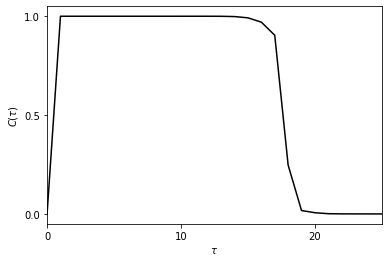

In [4]:
delays,mf1d = ipc.mf1d(path,th_scale=1.2)

plt.figure()
plt.plot(delays,mf1d,'k-')
plt.xlim(0,25)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C(\tau)$')
plt.xticks([0,10,20])
plt.yticks([0,0.5,1])
plt.savefig('sample2_1d_memory_function.png',dpi=300,facecolor="w",edgecolor="w")

2. Second-order memory function

The second-order memory function $C(\tau_1,\tau_2)$ represents the second-order IPC of $\zeta_{t-\tau_1}\zeta_{t-\tau_2}$ held in a reservoir. 
The method `single_input_ipc.mf2d()` returns the second-order memory function `mf2d` $\{C(\tau_1,\tau_2)\}$ with its corresponding delays `delays` $\{\tau\}$. 
In the same manner as the first-order, when `zerobased`==True (False), the range of `delays` is from $0$ ($1$) to the maximum delay $\tau_{\rm max}$ in `degdelays` = [[2, $\tau_{\rm max}$]]. 

(30,) (30, 30)


/tmp/ipykernel_2432305/4056123787.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolor(delays,delays,mf2d)


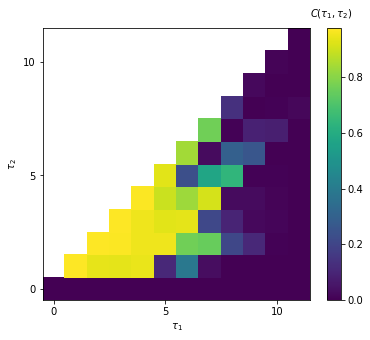

In [7]:
delays,mf2d = ipc.mf2d(path,th_scale=1.2)
print(delays.shape,mf2d.shape)
# Plot ipc decomposition
fig,ax = plt.subplots(figsize=(6,5))
c = ax.pcolor(delays,delays,mf2d)
fig.colorbar(c, ax=ax) 
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
ax.set_xticks([0.5,5.5,10.5])
ax.set_xticklabels([0,5,10])
ax.set_yticks([0.5,5.5,10.5])
ax.set_yticklabels([0,5,10])
ax.text(12,12.5,r'$C(\tau_1,\tau_2)$')
plt.savefig('sample2_2d_memory_function.png',dpi=300,facecolor="w",edgecolor="w")

